In [67]:
using MiniOps
using LinearAlgebra
using Plots, FFTW

In [ ]:
function test_conv()

    h = randn(15)
    A = conv1d_op(h)

    x1 = randn(120) 
    y1 = A*x1
    
    y2 = randn(size(y1))
    x2 = A'*y2

println("<y1, y2> - <x1, x2>: ", y1'*y2 -x2'*x1)
println(A.name, " size : ", A.m, A.n)

end

test_conv()

In [2]:

function test_composition()

  println("Testing do-product for A = S1*R*S2")
  println("S1 is scaling")
  println("S2 applies diag weights")
  println("R is sampling")

    nx, ny = 20, 30
    full_size = (nx, ny)
    mask = rand(nx * ny) .> 0.7
    idx  = findall(mask)
    
    R = sampling_op(idx, full_size)
    S1 = scaling_op(3.0)
    S2 = diag_op(ones(nx,ny))
    x1 = randn(nx, ny)
    y1 = S1 * R * S2 *x1
    y2 = randn(size(y1))

     A = S1*R*S2
    x2 = S2'*R'*S1'*y2

println("<x1,x2> = ", dot(x1,x2))
println("<y1,y2> = ", dot(y2,y1))
println(A.name, A.m, A.n)
end
    
test_composition()

Testing do-product for A = S1*R*S2
S1 is scaling
S2 applies diag weights
R is sampling
<x1,x2> = 29.368079917855642
<y1,y2> = 29.368079917855635
scaling*sampling*diag-1-1


In [ ]:
  A = fft_op(randn(ComplexF64,20,20))
# A = fft_op()

x1 = randn(ComplexF64,20,20)
y1 = A*x1

y2 = randn(ComplexF64,20,20)
x2 = A'*y2

println("<x1,x2> = ", round(dot(x1,x2), digits=8))
println("<y1,y2> = ", round(dot(y1,y2), digits=8))

println(A.name," m : ", A.m, " n : ", A.n)

A = with_shape(A, x1)
println(A.name," m : ", A.m, " n : ", A.n)


<x1,x2> = 10.88086797 + 4.07541472im
<y1,y2> = 10.88086797 + 4.07541472im
fft_planned m : 400 n : 400
fft_planned m : 400 n : 400


In [35]:
function test_conv_multichannel()

    wavelet = rand(10)
    A = conv1d_cols_op(wavelet)

    x1 = randn(200,100)
    y1 = A*x1

    y2 = randn(size(y1))
    x2 = A'*y2

println("<x1,x2> = ", dot(x1,x2))
println("<y1,y2> = ", dot(y1,y2))
    
println(A.name," m : ", A.m, " n : ", A.n)

end
test_conv_multichannel()

<x1,x2> = 640.2957486626995
<y1,y2> = 640.2957486626996
conv1d_cols m : -1 n : -1


In [36]:
# Soft-threshold for real or complex arrays
function soft_threshold(u, tau)
    # tau >= 0 (scalar)
    amp    = abs.(u)
    denom  = amp .+ eps(Float64)   # avoid division by zero
    factor = max.(0.0, 1 .- tau ./ denom)
    return factor .* u
end

# ISTA: solves
#   min_u  0.5 * ||A*u - y||_2^2 + mu * ||u||_1
#
# Inputs:
#   A         - MiniOps.Op operator
#   y         - data (same shape as A*u)
#   u0        - initial model (same shape as solution u)
#   mu        - L1 penalty weight
#   step_size - gradient step size
#   niter     - number of iterations
#
# Output:
#   u         - ISTA solution
function ista(A, y, u0, mu, step_size; niter=100, verbose=false)
    u = copy(u0)

    for k in 1:niter
        # Gradient of 0.5 * ||A*u - y||^2
        r = A * u .- y
        g = A' * r

        # Gradient step on L2 term
        u .= u .- step_size .* g

        # Prox step (soft-threshold) for L1
        u .= soft_threshold(u, mu * step_size)

        if verbose && (k % 10 == 0)
            @show k, maximum(abs.(r))
        end
    end

    return u
end

ista (generic function with 1 method)

In [97]:
# demo Fourier reconstruction with SD 

    nx, ny= 256, 256
    full_size = (nx, ny)
    mask = rand(nx * ny) .> 0.8
    idx  = findall(mask)
    
 R = sampling_op(idx, full_size)
 F = fft_op(rand(nx,ny))

 x = zeros(ComplexF64,nx,ny)
 x[2,2] =     3.0 + im*3.0
 x[4,10] =  -3.0 - im*3.0
 x[10,4] =  -3.0 - im*3.0
 A = R*F
 DATA=F*x
 y = A*x
u0=randn(nx,ny)+im*randn(nx,ny)
e = opnorm_power(A,u0)
println(e)
step_size = 0.98/e^2
u = ista(A, y, u0, 0.11, step_size; niter=100, verbose=false);



1.0


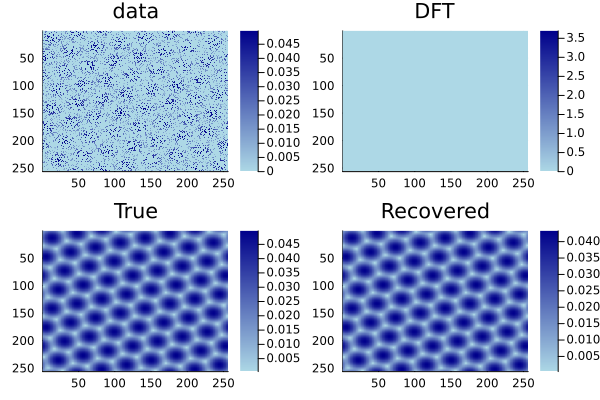

In [98]:

p1 = heatmap(abs.(R'*y), cmap=:blues, yflip=true, title="data")
p2 = heatmap(fftshift((abs.(u))),  cmap=:blues, yflip=true, title="DFT")
p3 = heatmap(abs.(DATA), cmap=:blues, yflip=true, title="True")
p4 = heatmap(abs.(F*u),  cmap=:blues, yflip=true, title="Recovered")
plot(p1, p2, p3, p4, layout = (2,2))

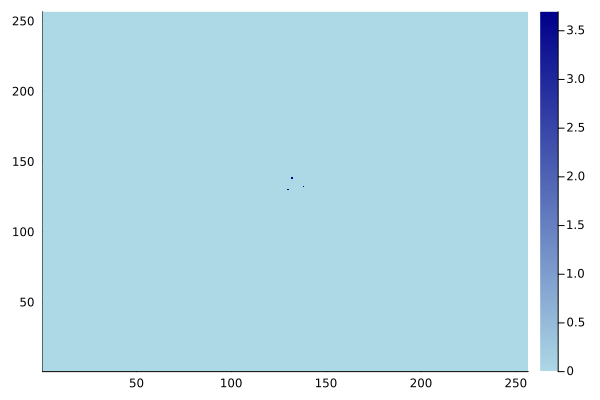

In [99]:
heatmap(fftshift(abs.(u)),cmap=:blues)